In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
# library(Seurat)
library(CellChat)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 载入需要的程辑包：igraph

R[write to console]: 
载入程辑包：‘igraph’


R[write to console]: The following objects are masked from ‘package:lubridate’:

    %--%, union


R[write to console]: The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


R[write to console]: The following objects are masked from ‘package:purrr’:

    compose, simplify


R[write to console]: The following object is masked from ‘package:tidyr’:

    crossing


R[write to console]: The following object is masked from ‘package:tibble’:

    as_data_frame


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union





    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [3]:
%%R
# in R
adata1 = dior::read_h5(file='/home/maolp/data5/Gaofeng_All_matrix/Allcount/All_scanpyData/Data/scdata.h5', target.object = 'seurat')

R[write to console]: Warning:
R[write to console]:  No columnames present in cell embeddings, setting to 'PCA_1:50'

R[write to console]: Warning:
R[write to console]:  No columnames present in cell embeddings, setting to 'UMAP_1:2'



In [4]:
%%R
adata1
# adata1@meta.data %>% head()

An object of class Seurat 
31424 features across 245834 samples within 1 assay 
Active assay: RNA (31424 features, 0 variable features)
 2 dimensional reductions calculated: pca, umap


In [5]:
%%R
# Load the required packages
library(dplyr)
library(stringr)

# Add a new column to the metadata
adata1@meta.data <- adata1@meta.data %>% mutate(
  Category = case_when(
    # Identify the initial letter
    str_detect(AdjustedID, "^B") ~ "PBMC",
    str_detect(AdjustedID, "^L") ~ "Liver",
    str_detect(AdjustedID, "^T") ~ "Thymus",
    str_detect(AdjustedID, "^S") ~ "Spleen",
    TRUE ~ "Other"  # for any other cases
  ),
  NumericPart = as.numeric(str_extract(AdjustedID, "\\d+\\.\\d+")),  # extract the numeric part
  Stage = ifelse(NumericPart <= 26, "Early", "Late")  # classify as "Early" or "Late"
)

adata1@meta.data$GroupStat<-paste0(adata1@meta.data$Category,"_",adata1@meta.data$Stage)

In [6]:
%%R
process_cellchat233 <- function(adata,  id_value) {
  subset_data <- subset(adata, GroupStat== id_value)
  data.pbmc <- subset_data@assays$RNA@data
  # Use cell_type_label as the name of the column to use for group labels
  cellmeta <- data.frame(group = as.character(subset_data$Last_cell_type), row.names = names(subset_data$Last_cell_type))
#   print("test3")
  print(paste("Cellmeta rows: ", nrow(cellmeta)))
  print(paste("Subset data cells: ", length(subset_data@meta.data$Last_cell_type)))
  cellchat <- createCellChat(object = data.pbmc)
  cellchat <- addMeta(cellchat, meta = cellmeta, meta.name = "labels")
  cellchat <- setIdent(cellchat, ident.use = "labels")
  
  CellChatDB <- CellChatDB.human
  CellChatDB.use <- subsetDB(CellChatDB, search = "Cell-Cell Contact", key = "annotation")
  cellchat@DB <- CellChatDB.use
  
  cellchat <- subsetData(cellchat)
  cellchat <- identifyOverExpressedGenes(cellchat)
  cellchat <- identifyOverExpressedInteractions(cellchat)
  cellchat <- projectData(cellchat, PPI.human)

  cellchat <- computeCommunProb(cellchat)
  cellchat <- computeCommunProbPathway(cellchat)
  cellchat <- aggregateNet(cellchat)
  
  return(cellchat)
}




In [7]:
%%R
unique(adata1@meta.data$GroupStat)


[1] "PBMC_Early"   "PBMC_Late"    "Thymus_Early" "Spleen_Early" "Liver_Early" 


In [8]:
%%R
# unique(adata1$GroupStat)
# unique(adata1$Cell_lineage)
subadata1<-subset(adata1,Cell_lineage !="OTHERS")
subadata1<-subset(adata1,Cell_lineage !="MK/ERY")

In [9]:
%%R
# Get a list of all unique AdjustedID values
# # adjusted_ids <- unique(adata1$AdjustedID)
GroupStat_ids <- c( "PBMC_Early","PBMC_Late" ,"Liver_Early","Thymus_Early", "Spleen_Early")
Organ_results <- lapply(GroupStat_ids, function(id) process_cellchat233(adata1, id))
saveRDS(Organ_results, file = "/home/maolp/Allcount/All_scanpyData/Cellchat/Organ_results.rds")

[1] "Cellmeta rows:  89708"
[1] "Subset data cells:  89708"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~11s           |++                                                | 3 % ~11s           |+++                                               | 5 % ~10s           |+++                                               | 6 % ~10s           |++++                                              | 7 % ~10s           |++++                                              | 8 % ~10s           |+++++                                             | 9 % ~11s           |++++++                                            | 10% ~10s           |++++++                                            | 11% ~10s           |+++++++                                           | 12% ~10s           |+++++++                

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~11s           |++                                                | 4 % ~10s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~10s           |++++                                              | 8 % ~10s           |+++++                                             | 9 % ~10s           |+++++                                             | 10% ~10s           |++++++                                            | 11% ~09s           |+++++++                                           | 12% ~10s           |+++++++                                           | 14% ~09s           |++++++++                                          | 15% ~09s           |+++++++++                                         | 16% ~09s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~12s           |++                                                | 2 % ~10s           |++                                                | 4 % ~11s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~10s           |++++                                              | 7 % ~10s           |+++++                                             | 9 % ~10s           |+++++                                             | 10% ~10s           |++++++                                            | 11% ~10s           |+++++++                                           | 12% ~09s           |+++++++                                           | 14% ~09s           |++++++++                                          | 15% ~09s           |+++++++++                                         | 16% ~09s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 3 % ~08s           |+++                                               | 4 % ~08s           |+++                                               | 5 % ~08s           |++++                                              | 7 % ~08s           |+++++                                             | 8 % ~08s           |+++++                                             | 9 % ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 12% ~08s           |+++++++                                           | 14% ~08s           |++++++++                                          | 15% ~08s           |+++++++++                                         | 16% ~08s           |+++++++++                                         | 18% ~08s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~08s           |++                                                | 3 % ~07s           |+++                                               | 5 % ~07s           |++++                                              | 7 % ~07s           |+++++                                             | 9 % ~07s           |++++++                                            | 10% ~07s           |+++++++                                           | 12% ~07s           |+++++++                                           | 14% ~07s           |++++++++                                          | 16% ~07s           |+++++++++                                         | 17% ~06s           |++++++++++                                        | 19% ~06s           |+++++++++++                                       | 21% ~06s           |++++++++++++                                      | 22% ~06s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~10s           |++                                                | 2 % ~10s           |++                                                | 3 % ~10s           |+++                                               | 4 % ~10s           |+++                                               | 5 % ~10s           |++++                                              | 6 % ~10s           |++++                                              | 7 % ~10s           |+++++                                             | 8 % ~10s           |+++++                                             | 9 % ~10s           |++++++                                            | 10% ~10s           |++++++                                            | 11% ~10s           |+++++++                                           | 12% ~10s           |+++++++                                           | 14% ~10s 

  |                                                  | 0 % ~calculating   |++                                                | 3 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 8 % ~04s           |++++++                                            | 10% ~04s           |+++++++                                           | 13% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 18% ~04s           |+++++++++++                                       | 21% ~04s           |++++++++++++                                      | 23% ~03s           |+++++++++++++                                     | 26% ~03s           |+++++++++++++++                                   | 28% ~03s           |++++++++++++++++                                  | 31% ~03s           |+++++++++++++++++                                 | 33% ~03s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~14s           |+                                                 | 2 % ~12s           |++                                                | 3 % ~12s           |++                                                | 4 % ~11s           |+++                                               | 5 % ~11s           |+++                                               | 6 % ~11s           |++++                                              | 7 % ~11s           |++++                                              | 8 % ~11s           |+++++                                             | 9 % ~11s           |+++++                                             | 10% ~11s           |++++++                                            | 11% ~11s           |++++++                                            | 12% ~11s           |+++++++                                           | 13% ~11s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~09s           |++                                                | 2 % ~09s           |++                                                | 4 % ~09s           |+++                                               | 5 % ~08s           |++++                                              | 6 % ~08s           |++++                                              | 7 % ~08s           |+++++                                             | 9 % ~08s           |+++++                                             | 10% ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 12% ~08s           |+++++++                                           | 14% ~08s           |++++++++                                          | 15% ~08s           |+++++++++                                         | 16% ~08s 

  |                                                  | 0 % ~calculating   |++                                                | 2 % ~05s           |+++                                               | 4 % ~05s           |++++                                              | 7 % ~05s           |+++++                                             | 9 % ~05s           |++++++                                            | 11% ~05s           |+++++++                                           | 13% ~05s           |++++++++                                          | 15% ~05s           |+++++++++                                         | 17% ~04s           |++++++++++                                        | 20% ~04s           |+++++++++++                                       | 22% ~04s           |++++++++++++                                      | 24% ~04s           |++++++++++++++                                    | 26% ~04s           |+++++++++++++++                                   | 28% ~04s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~09s           |++                                                | 2 % ~09s           |++                                                | 4 % ~08s           |+++                                               | 5 % ~08s           |++++                                              | 6 % ~08s           |++++                                              | 8 % ~08s           |+++++                                             | 9 % ~08s           |+++++                                             | 10% ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 12% ~08s           |+++++++                                           | 14% ~08s           |++++++++                                          | 15% ~08s           |+++++++++                                         | 16% ~08s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~07s           |++                                                | 3 % ~07s           |+++                                               | 5 % ~07s           |++++                                              | 6 % ~07s           |++++                                              | 8 % ~07s           |+++++                                             | 9 % ~07s           |++++++                                            | 11% ~07s           |+++++++                                           | 12% ~06s           |++++++++                                          | 14% ~06s           |++++++++                                          | 16% ~06s           |+++++++++                                         | 17% ~06s           |++++++++++                                        | 19% ~06s           |+++++++++++                                       | 20% ~06s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~11s           |++                                                | 3 % ~09s           |+++                                               | 4 % ~09s           |+++                                               | 5 % ~08s           |++++                                              | 7 % ~09s           |+++++                                             | 8 % ~08s           |+++++                                             | 9 % ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 12% ~09s           |+++++++                                           | 14% ~09s           |++++++++                                          | 15% ~08s           |+++++++++                                         | 16% ~08s           |+++++++++                                         | 18% ~08s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~13s           |++                                                | 2 % ~12s           |++                                                | 3 % ~11s           |+++                                               | 4 % ~10s           |+++                                               | 5 % ~11s           |++++                                              | 7 % ~11s           |++++                                              | 8 % ~10s           |+++++                                             | 9 % ~11s           |+++++                                             | 10% ~11s           |++++++                                            | 11% ~11s           |++++++                                            | 12% ~11s           |+++++++                                           | 13% ~10s           |++++++++                                          | 14% ~10s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~09s           |++                                                | 2 % ~09s           |++                                                | 4 % ~09s           |+++                                               | 5 % ~09s           |++++                                              | 6 % ~09s           |++++                                              | 7 % ~09s           |+++++                                             | 9 % ~09s           |+++++                                             | 10% ~10s           |++++++                                            | 11% ~09s           |+++++++                                           | 12% ~09s           |+++++++                                           | 13% ~09s           |++++++++                                          | 15% ~09s           |++++++++                                          | 16% ~09s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~09s           |++                                                | 3 % ~08s           |+++                                               | 5 % ~08s           |++++                                              | 6 % ~08s           |++++                                              | 8 % ~08s           |+++++                                             | 9 % ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 12% ~08s           |+++++++                                           | 14% ~08s           |++++++++                                          | 15% ~07s           |+++++++++                                         | 17% ~07s           |++++++++++                                        | 18% ~07s           |++++++++++                                        | 20% ~07s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~11s           |++                                                | 3 % ~09s           |+++                                               | 4 % ~09s           |+++                                               | 5 % ~09s           |++++                                              | 7 % ~08s           |+++++                                             | 8 % ~09s           |+++++                                             | 9 % ~08s           |++++++                                            | 11% ~09s           |+++++++                                           | 12% ~09s           |+++++++                                           | 14% ~09s           |++++++++                                          | 15% ~09s           |+++++++++                                         | 16% ~08s           |+++++++++                                         | 18% ~08s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 2 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10% ~00s           |++++++                                            | 11% ~00s           |+++++++                                           | 12% ~00s           |+++++++                                           | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 16% ~00s 

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                            
  |==                                                                    |   2%
  |                                                                            
  |==                                                                    |   3%
  |                                     

  |========================                                              |  34%
  |                                                                            
  |========================                                              |  35%
  |                                                                            
  |=========================                                             |  35%
  |                                                                            
  |=========================                                             |  36%
  |                                                                            
  |==========================                                            |  37%
  |                                                                            
  |==========================                                            |  38%
  |                                                                            
  |===========================          

  |                                                                            
  |================================================                      |  69%
  |                                                                            
  |=================================================                     |  69%
  |                                                                            
  |=================================================                     |  70%
  |                                                                            
  |=================================================                     |  71%
  |                                                                            
  |==================================================                    |  71%
  |                                                                            
  |==================================================                    |  72%
  |                                     

[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-16 22:00:51]"
[1] "Cellmeta rows:  82724"
[1] "Subset data cells:  82724"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~10s           |++                                                | 2 % ~09s           |++                                                | 4 % ~09s           |+++                                               | 5 % ~08s           |++++                                              | 6 % ~08s           |++++                                              | 7 % ~08s           |+++++                                             | 9 % ~08s           |+++++                                             | 10% ~09s           |++++++                                            | 11% ~09s           |+++++++                                      

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~05s           |++                                                | 3 % ~05s           |+++                                               | 5 % ~05s           |++++                                              | 7 % ~05s           |+++++                                             | 8 % ~06s           |++++++                                            | 10% ~06s           |++++++                                            | 12% ~06s           |+++++++                                           | 14% ~06s           |++++++++                                          | 15% ~06s           |+++++++++                                         | 17% ~06s           |++++++++++                                        | 19% ~06s           |+++++++++++                                       | 20% ~05s           |++++++++++++                                      | 22% ~05s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~09s           |++                                                | 3 % ~08s           |+++                                               | 4 % ~08s           |+++                                               | 5 % ~08s           |++++                                              | 7 % ~08s           |+++++                                             | 8 % ~08s           |+++++                                             | 10% ~08s           |++++++                                            | 11% ~08s           |+++++++                                           | 12% ~08s           |+++++++                                           | 14% ~08s           |++++++++                                          | 15% ~08s           |+++++++++                                         | 16% ~07s           |+++++++++                                         | 18% ~07s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~06s           |++                                                | 4 % ~06s           |+++                                               | 5 % ~06s           |++++                                              | 7 % ~06s           |+++++                                             | 9 % ~06s           |++++++                                            | 11% ~06s           |+++++++                                           | 12% ~06s           |++++++++                                          | 14% ~06s           |++++++++                                          | 16% ~06s           |+++++++++                                         | 18% ~05s           |++++++++++                                        | 19% ~05s           |+++++++++++                                       | 21% ~05s           |++++++++++++                                      | 23% ~05s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~06s           |++                                                | 3 % ~06s           |+++                                               | 5 % ~06s           |++++                                              | 6 % ~06s           |+++++                                             | 8 % ~06s           |+++++                                             | 10% ~06s           |++++++                                            | 11% ~06s           |+++++++                                           | 13% ~06s           |++++++++                                          | 15% ~06s           |+++++++++                                         | 16% ~06s           |+++++++++                                         | 18% ~06s           |++++++++++                                        | 19% ~06s           |+++++++++++                                       | 21% ~05s 

  |                                                  | 0 % ~calculating   |++                                                | 4 % ~02s           |++++                                              | 8 % ~02s           |++++++                                            | 12% ~02s           |++++++++                                          | 16% ~02s           |++++++++++                                        | 20% ~02s           |++++++++++++                                      | 24% ~02s           |++++++++++++++                                    | 28% ~02s           |++++++++++++++++                                  | 32% ~02s           |++++++++++++++++++                                | 36% ~02s           |++++++++++++++++++++                              | 40% ~02s           |++++++++++++++++++++++                            | 44% ~01s           |++++++++++++++++++++++++                          | 48% ~01s           |++++++++++++++++++++++++++                        | 52% ~01s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 3 % ~07s           |+++                                               | 4 % ~07s           |+++                                               | 6 % ~07s           |++++                                              | 7 % ~07s           |+++++                                             | 9 % ~07s           |++++++                                            | 10% ~07s           |++++++                                            | 12% ~07s           |+++++++                                           | 13% ~07s           |++++++++                                          | 15% ~07s           |+++++++++                                         | 16% ~07s           |+++++++++                                         | 18% ~06s           |++++++++++                                        | 19% ~06s 

In [32]:
%%R
GroupStat_ids <- c( "PBMC_Early","PBMC_Late" ,"Liver_Early","Thymus_Early", "Spleen_Early")
Organ_results2 <- lapply(GroupStat_ids, function(id) process_cellchat233(subadata1, id))
saveRDS(Organ_results, file = "/home/maolp/Allcount/All_scanpyData/Cellchat/Organ_results2.rds")

[1] "Cellmeta rows:  56104"
[1] "Subset data cells:  56104"
[1] "Create a CellChat object from a data matrix"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08s           |++                                                | 2 % ~07s           |++                                                | 4 % ~06s           |+++                                               | 5 % ~06s           |++++                                              | 6 % ~06s           |++++                                              | 7 % ~06s           |+++++                                             | 9 % ~06s           |+++++                                             | 10% ~06s           |++++++                                            | 11% ~06s           |+++++++                                           | 12% ~06s           |+++++++                                           | 14% ~06s           |++++++++               

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~05s           |++                                                | 3 % ~06s           |+++                                               | 4 % ~06s           |+++                                               | 6 % ~06s           |++++                                              | 7 % ~06s           |+++++                                             | 9 % ~06s           |++++++                                            | 10% ~06s           |++++++                                            | 12% ~06s           |+++++++                                           | 13% ~06s           |++++++++                                          | 14% ~06s           |++++++++                                          | 16% ~06s           |+++++++++                                         | 17% ~05s           |++++++++++                                        | 19% ~05s 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~07s           |++                                                | 3 % ~06s           |+++                                               | 4 % ~06s           |+++                                               | 6 % ~06s           |++++                                              | 7 % ~06s           |+++++                                             | 9 % ~05s           |++++++                                            | 10% ~06s           |++++++                                            | 12% ~06s           |+++++++                                           | 13% ~05s           |++++++++                                          | 15% ~06s           |+++++++++                                         | 16% ~05s           |+++++++++                                         | 18% ~05s           |++++++++++                                        | 19% ~05s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~04s           |++                                                | 3 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 7 % ~04s           |+++++                                             | 8 % ~04s           |++++++                                            | 10% ~04s           |++++++                                            | 12% ~04s           |+++++++                                           | 14% ~04s           |++++++++                                          | 15% ~04s           |+++++++++                                         | 17% ~04s           |++++++++++                                        | 19% ~04s           |+++++++++++                                       | 20% ~04s           |++++++++++++                                      | 22% ~04s 

  |                                                  | 0 % ~calculating   |+                                                 | 2 % ~04s           |++                                                | 4 % ~04s           |+++                                               | 5 % ~04s           |++++                                              | 7 % ~04s           |+++++                                             | 9 % ~04s           |++++++                                            | 11% ~04s           |+++++++                                           | 12% ~04s           |++++++++                                          | 14% ~04s           |+++++++++                                         | 16% ~04s           |+++++++++                                         | 18% ~03s           |++++++++++                                        | 20% ~03s           |+++++++++++                                       | 21% ~03s           |++++++++++++                                      | 23% ~03s 

In [33]:
%%R
Organ_cellchat2 <- mergeCellChat(Organ_results2, add.names =GroupStat_ids)

In [34]:
%%R -w 3000 -h 1000 -r 300
gg1 <- compareInteractions(Organ_cellchat2 , show.legend = F, group = c(1,2,3,4,5))+scale_fill_manual(values = c("#FFA300","#F6313E", "#fb862b", "#0eb0c8", "#6a73cf"))
gg2 <- compareInteractions(Organ_cellchat2 , show.legend = F, group = c(1,2,3,4,5), measure = "weight")+scale_fill_manual(values = c("#FFA300","#F6313E", "#fb862b", "#0eb0c8", "#6a73cf"))
gg1 + gg2

In [35]:
%%R
object.list<-readRDS("/home/maolp/Allcount/All_scanpyData/Cellchat/Organ_results2.rds")
object.list <- lapply(object.list, function(x) netAnalysis_computeCentrality(x, slot.name = "netP"))

In [36]:
%%R
GroupStat_ids <- c( "PBMC_Early","PBMC_Late" ,"Liver_Early","Thymus_Early", "Spleen_Early")
names(object.list)<-GroupStat_ids 

In [37]:
# %%R
# num.link

In [38]:
%%R -w 3000 -h 1200 -r 180
library(ggsci)
cols01 <- c("#f49128", "#194a55", "#187c65", "#f26115", "#c29f62", "#83ba9e")
cols02 <- c("#c62d17", "#023f75", "#ea894e", "#266b69", "#eb4601", "#f6c619")
cols03 <- c("#fa6e01", "#2f2f2f", "#972b1d", "#e6a84b", "#4c211b", "#ff717f")
cols04 <- c("#223e9c", "#b12b23", "#aebea6", "#edae11", "#0f6657", "#c74732")
cols05 <- c("#6a73cf", "#edd064", "#0eb0c8", "#f2ccac", "#a1d5b9", "#e1abbc")

all_colors <- c(cols01, cols02, cols03, cols04, cols05)
all_colors
colorname2=c(pal_futurama()(3),"#46A040","#00AF99" ,"#F6313E", "#FFA300","#2f2f2f",  "#FFC179", 
"#FF5A00", "#663366","#FF6666","#8F1336", "#0081C9", "#001588", "#CC0033",
"#CC9966","#CC0033","#999933","#009966","#CCCC33","#CCFF99","#0eb0c8","#993333","#333366",
"#490C65", "#BA7FD0","#A6CEE3", "#1F78B4", "#DE77AE", "#B2DF8A", "#006D2C", "#B5AD64",
"#9DA8E2","#91C392", "#194a55", "#187c65", "#c29f62","#f49128","#c62d17", "#333329",
"#023f75", "#ea894e", "#266b69",  "#e1abbc","#f6c619","#fa6e01", "#972b1d", "#e6a84b", "#4c211b", "#ff717f","#223e9c", 
"#aebea6", "#edae11", "#c74732", "#6a73cf", "#edd064" , 
"#0eb0c8", "#f2ccac" ,"#868686","#339966", "#83ba9e", "#b12b23", "#0f6657","#f26115","#eb4601")
colorname3=colorname2
length(colorname3)

In [39]:
ls /home/maolp/Allcount/All_scanpyData/ColorDict/

In [40]:
%%R -w 1800 -h 2600 -r 180

library(jsonlite)


file_path <- "/home/maolp/Allcount/All_scanpyData/ColorDict/Celltype_colors_dict_nonum.json"
colors_dict <- fromJSON(file_path)
colors_dict

In [41]:
%%R -w 8000 -h 3000 -r 300

num.link <- sapply(object.list, function(x) {rowSums(x@net$count) + colSums(x@net$count)-diag(x@net$count)})
num.link 
weight.MinMax <- c(0,643) 

gg <- list()
for (i in 1:length(object.list)) {
  gg[[i]] <- netAnalysis_signalingRole_scatter(object.list[[i]], 
                                               title = names(object.list)[i], weight.MinMax = weight.MinMax, label.size = 6,
                                               font.size.title = 30)+ylab("")+theme(
      axis.title.x = element_text(size=18), axis.text.x= element_text(size=18),
                                                                 axis.ticks.y = element_line(size = 2),  #
                                                            axis.text.y = element_text(size = 14)) + scale_color_manual(values = colors_dict)+
    scale_y_continuous(breaks = seq(0, 60, by = 10))+coord_cartesian(ylim = c(0, 60),xlim = c(0, 18))+scale_x_continuous(breaks = seq(0, 18, by = 3))
}
patchwork::wrap_plots(plots = gg,ncol=5)

In [42]:
%%R -w 6000 -h 3000 -r 300
pdf("/home/maolp/Allcount/All_scanpyData/Cellchat/Organall.pdf",width=40,height=10)
print(patchwork::wrap_plots(plots = gg,ncol=5))
dev.off()

In [43]:
%%R -w 10000 -h 3000 -r 300
library(patchwork)


for (i in 2:5) {
  gg[[i]] <- gg[[i]] + guides(color = FALSE, fill = FALSE)
}


p <- wrap_plots(plots = gg, ncol = 5)

print(p)

In [44]:
%%R -w 6000 -h 3000 -r 300
pdf("/home/maolp/Allcount/All_scanpyData/Cellchat/Organall.pdf",width=40,height=10)
print(p)
dev.off()

In [45]:
%%R
netAnalysis_signalingRole_scatter

In [46]:
%%R
process_cellchat2 <- function(adata, adjusted_id) {
  subset_data <- subset(adata, AdjustedID == adjusted_id)
  data.pbmc <- subset_data@assays$RNA@data
  cellmeta <- data.frame(group = as.character(subset_data$Cell_lineage), row.names = names(subset_data$Cell_lineage))
  
  cellchat <- createCellChat(object = data.pbmc)
  cellchat <- addMeta(cellchat, meta = cellmeta, meta.name = "labels")
  cellchat <- setIdent(cellchat, ident.use = "labels")
  
  CellChatDB <- CellChatDB.human
  CellChatDB.use <- subsetDB(CellChatDB, search = "Cell-Cell Contact", key = "annotation")
  cellchat@DB <- CellChatDB.use
  
  cellchat <- subsetData(cellchat)
  cellchat <- identifyOverExpressedGenes(cellchat)
  cellchat <- identifyOverExpressedInteractions(cellchat)
  cellchat <- projectData(cellchat, PPI.human)

  cellchat <- computeCommunProb(cellchat)
  cellchat <- computeCommunProbPathway(cellchat)
  cellchat <- aggregateNet(cellchat)
  
  return(cellchat)
}

# Get a list of all unique AdjustedID values
adjusted_ids <- levels(adata1$AdjustedID)
adjusted_ids 
# # Run the function on all AdjustedID values and store the results in a list
# results2 <- lapply(adjusted_ids, function(id) process_cellchat2(adata1, id))

# # Save the results as an RDS file
# saveRDS(results2, file = "/home/maolp/Allcount/All_scanpyData/Cellchat/Allcellchat_results_celllieange.rds")

In [47]:
%%R

x <- levels(adata1$AdjustedID)

order <- c(grep("^[^TS]", x),grep("^T", x), grep("^S", x))


x <- x[match(order, seq_along(x))]

print(x)
adjusted_ids=x

results2 <- lapply(adjusted_ids, function(id) process_cellchat2(adata1, id))

# # Save the results as an RDS file
saveRDS(results2, file = "/home/maolp/Allcount/All_scanpyData/Cellchat/Allcellchat_results_celllieange.rds")

In [48]:
%%R -w 6000 -h 3000 -r 300
# object.list=GroupStat_res2
object.list[[1]]=netAnalysis_computeCentrality(object.list[[1]], slot.name = "netP") 
object.list[[2]]=netAnalysis_computeCentrality(object.list[[2]], slot.name = "netP") 
object.list[[3]]=netAnalysis_computeCentrality(object.list[[3]], slot.name = "netP") 
object.list[[4]]=netAnalysis_computeCentrality(object.list[[4]], slot.name = "netP") 
object.list[[5]]=netAnalysis_computeCentrality(object.list[[5]], slot.name = "netP") 
# netVisual_bubble(object.list, sources.use = c(1:30), targets.use =1 ,  comparison = c(1, 2), angle.x = 45)

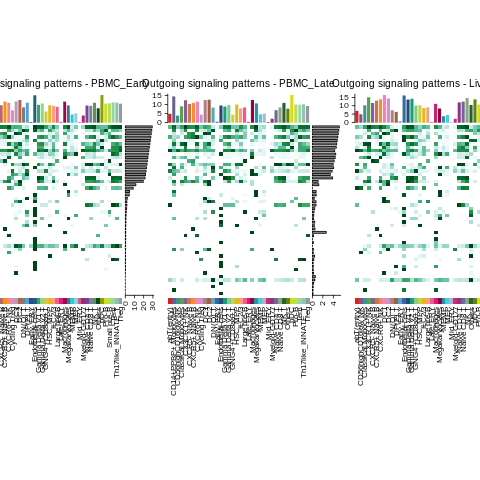

In [54]:
%%R
library(ComplexHeatmap)
i = 1
# combining all the identified signaling pathways from different datasets 
pathway.union <- union(object.list[[i]]@netP$pathways, object.list[[i+1]]@netP$pathways)
ht1 = netAnalysis_signalingRole_heatmap(object.list[[i]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i], width = 5, height = 6)
ht2 = netAnalysis_signalingRole_heatmap(object.list[[i+1]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i+1], width = 5, height = 6)
ht3 = netAnalysis_signalingRole_heatmap(object.list[[i+2]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i+2], width = 5, height = 6)

draw(ht1 + ht2+ht3, ht_gap = unit(0.5, "cm"))

R[write to console]: Comparing communications on a merged object 




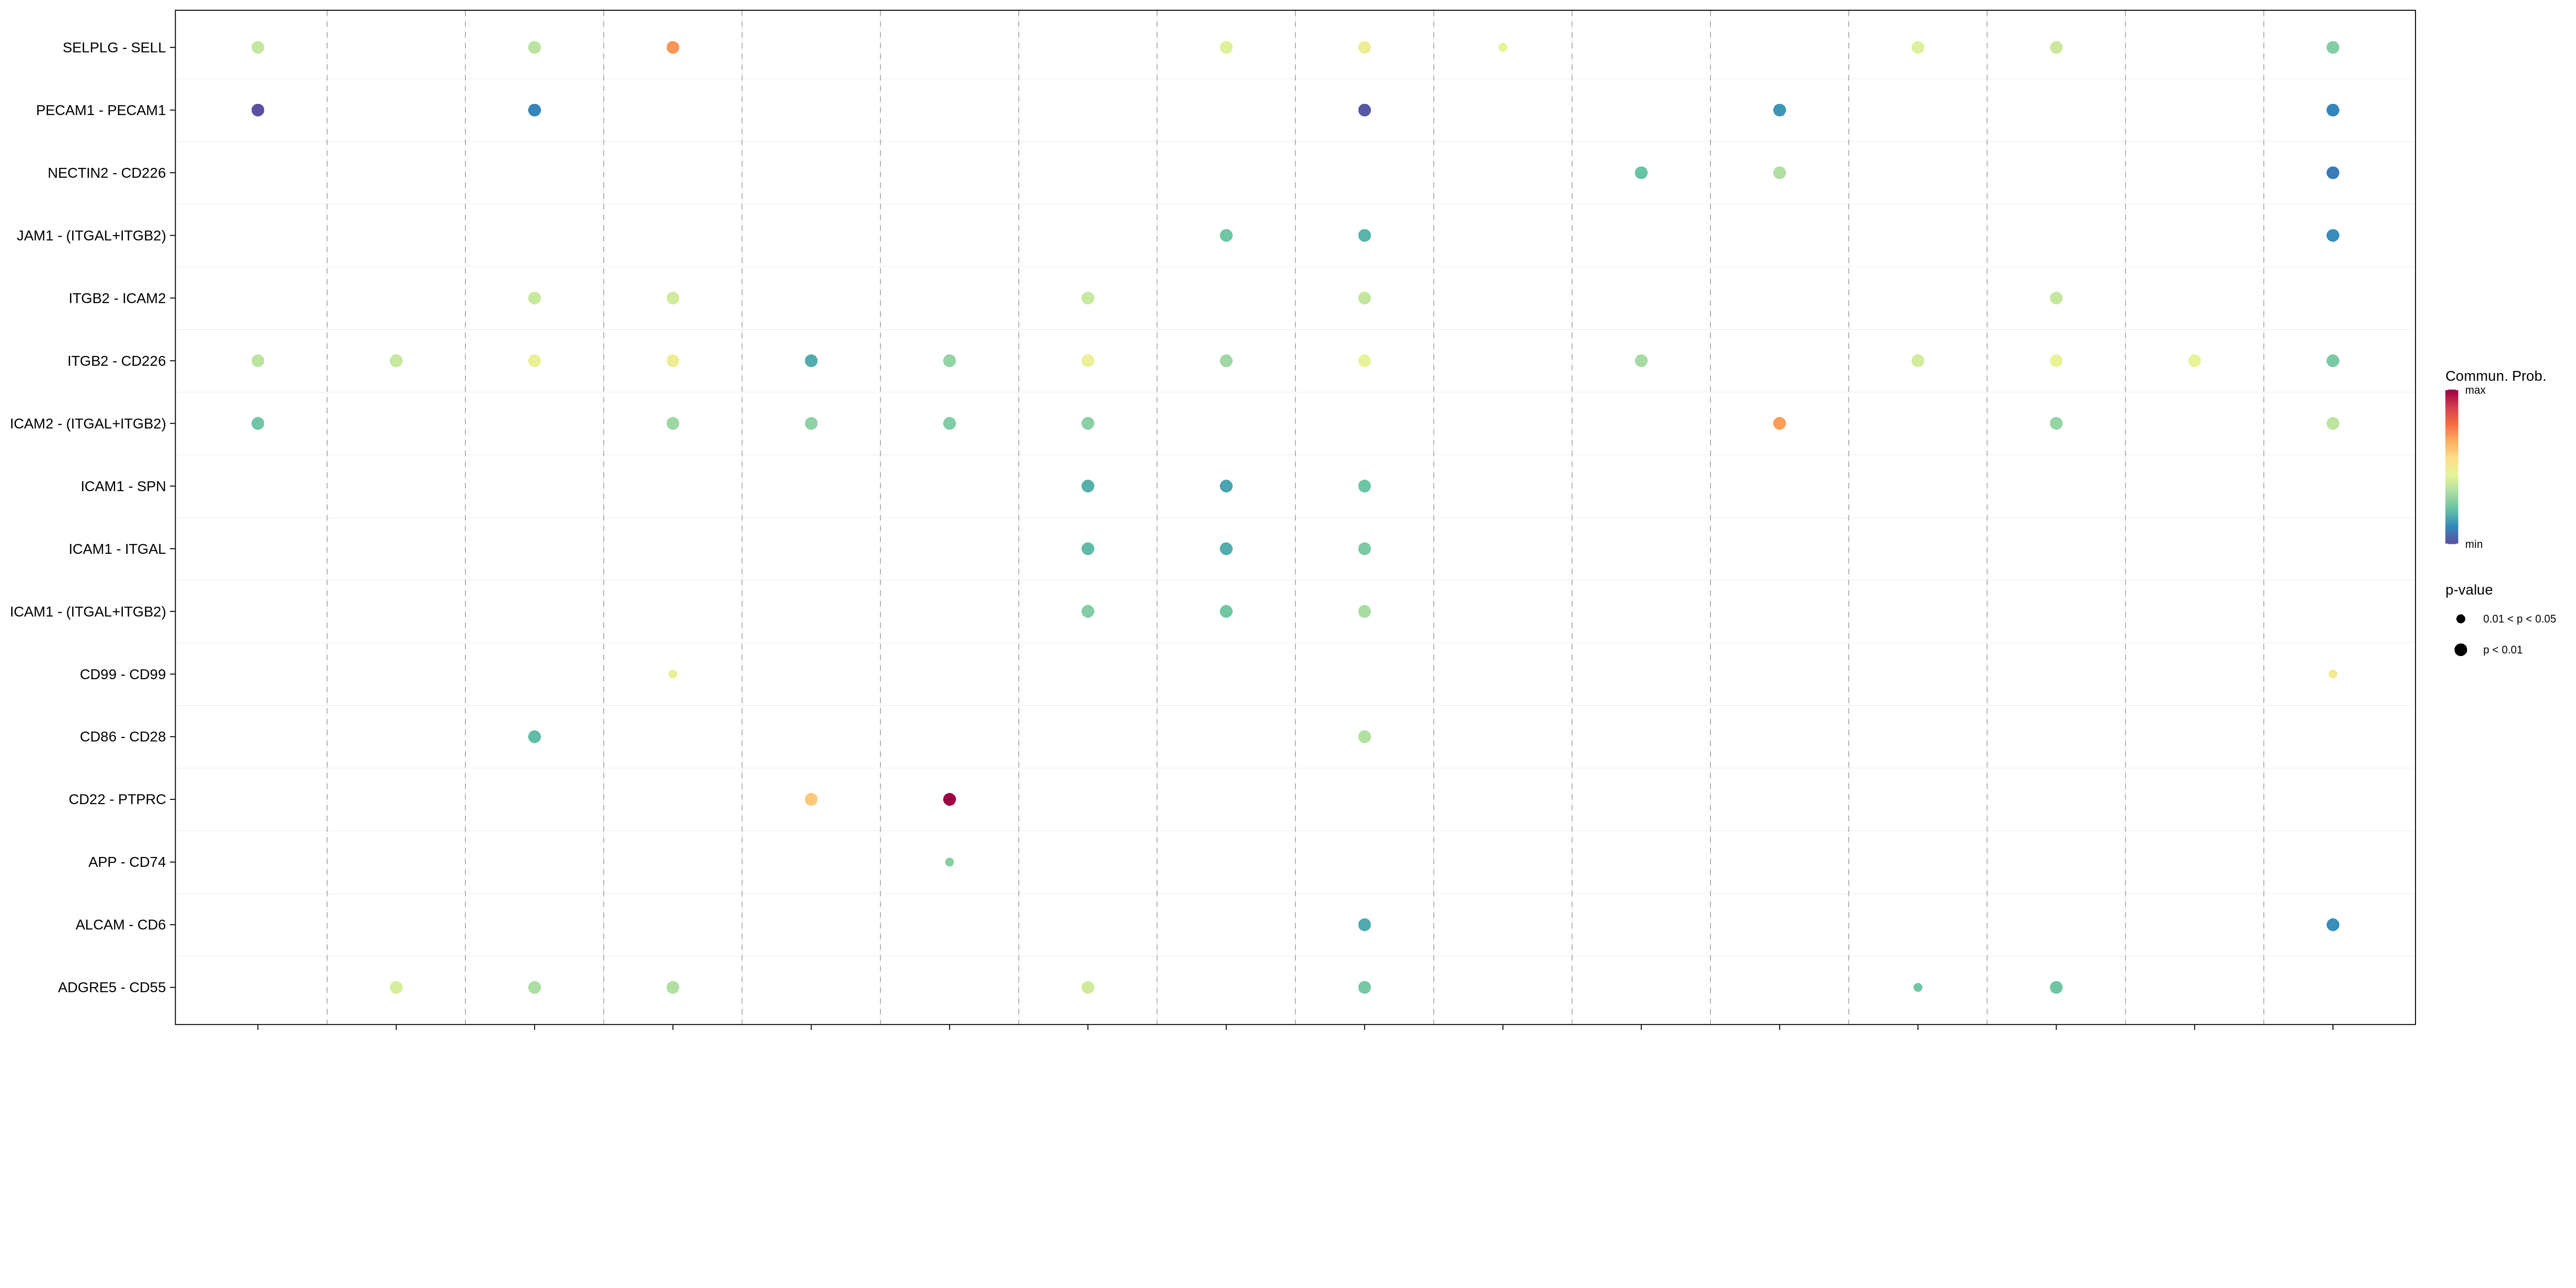

In [55]:
%%R -w 6000 -h 3000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:16) , targets.use = c(1),  comparison = c(5), angle.x = 45)

In [51]:
%%R
netVisual_bubble

In [52]:
%%R -w 2000 -h 2000 -r 300
netVisual_bubble(Organ_cellchat2, sources.use =c(1:30) , targets.use = c(1),  comparison = c(5), angle.x = 45)

In [ ]:
%%R
colnames(Organ_cellchat2@net$PBMC_Early$prob)